## 서울시의 스타벅스 매장 정보 수집

In [30]:
import mysql.connector

remote = mysql.connector.connect(
    host = 'database-1.czmyae8ssh29.ap-northeast-2.rds.amazonaws.com',
    port = 3306,
    user = 'root',
    password = '*****',
    database = '*****'
)

cursor = remote.cursor(buffered=True)

In [24]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import time

url = "https://www.starbucks.co.kr/store/store_map.do"
driver = webdriver.Chrome(service=Service("../driver/chromedriver"))
driver.set_window_size(1500, 1000)
driver.get(url)

WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "loca_search")))

local_search = driver.find_element(By.CLASS_NAME, "loca_search").click()

local_box = driver.find_element(By.CLASS_NAME, "sido_arae_box")
local_seoul = local_box.find_elements(By.TAG_NAME, "a")

for local in local_seoul:
    if local.text == '서울':
        local.click()

seoul = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, """//*[@id="mCSB_2_container"]/ul/li[1]/a""")))
seoul.click()

In [25]:
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "quickResultLstCon"))
)
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

In [26]:
seoul = soup.find("div", id="mCSB_3")
seoul.find("li", class_="quickResultLstCon")["data-name"]

'역삼아레나빌딩'

In [5]:
seoul.find("li", class_="quickResultLstCon")["data-lat"]

'37.501087'

In [6]:
seoul.find("li", class_="quickResultLstCon")["data-long"]

'127.043069'

In [27]:
seoul.find("li", class_="quickResultLstCon").find("p").get_text(separator="\n").split("\n")[0]

'서울특별시 강남구 언주로 425 (역삼동)'

In [28]:
seoul.find("li", class_="quickResultLstCon").find("p").get_text(separator="\n").split("\n")[0].split()[1]

'강남구'

In [32]:
seoul = soup.find("div", id="mCSB_3")
star_storelist = seoul.find_all("li", class_="quickResultLstCon")

sql = 'insert into starbucks values (%s,%s,%s,%s,%s)'

for each in star_storelist:
    star_name = each["data-name"]
    star_lat = each["data-lat"]
    star_long = each["data-long"]
    star_address = each.find("p").get_text(separator="\n").split("\n")[0]
    star_gu = star_address.split()[1]

    cursor.execute(sql, (star_name, star_lat, star_long, star_address, star_gu))
    remote.commit()



In [12]:
remote.close()

In [13]:
driver.close()

## 서울시의 이디야커피 매장 정보 수집

In [14]:
import mysql.connector

remote = mysql.connector.connect(
    host = 'database-1.czmyae8ssh29.ap-northeast-2.rds.amazonaws.com',
    port = 3306,
    user = 'root',
    password = '*****',
    database = '*****'
)

cursor = remote.cursor(buffered=True)

In [15]:
cursor.execute('select gu from starbucks group by gu')

gu_list = []
result = cursor.fetchall()
for row in result:
    gu_list.append('서울% ' + row[0])

In [16]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import time

url = "https://members.ediya.com/store"
driver = webdriver.Chrome(service=Service("../EDA/driver/chromedriver"))
driver.set_window_size(1500, 1000)
driver.get(url)


In [17]:
driver.find_element(By.XPATH, """//*[@id="contents"]/div/div/div[2]/div[1]/div[1]/a[2]""").click()

In [18]:
from tqdm.notebook import tqdm
import requests
import json

for idx, each_gu in tqdm(enumerate(gu_list), total=len(gu_list)):

    search = driver.find_element(By.ID, "keyword")
    search.click()    
    driver.implicitly_wait(3)
    search.send_keys(each_gu)
    search.send_keys(Keys.ENTER)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, "store_wrap"))
    )

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    store_list = soup.find("div", class_="store_list").find_all("div", class_="st_li")
    
    for store in store_list:
        ediya_name = store.find("h4").text
        ediya_address = store.find("p").text
        ediya_gu = ediya_address.split()[1]

        key = "*****"
        url = "https://maps.googleapis.com/maps/api/place/textsearch/json?"
        params = {
            "query": "이디야 " + ediya_name,
            "key": key
        }

        response = requests.get(url, params=params)
        data = response.json()

        ediya_lat = None
        ediya_long = None

        if data.get('results'):
            try:
                ediya_lat = data['results'][0]['geometry']['location']['lat']
                ediya_long = data['results'][0]['geometry']['location']['lng']
            except (IndexError, KeyError):
                pass

        if ediya_lat is None:
            params = {
                "query": ediya_address,
                "key": key
            }
            response = requests.get(url, params=params)
            data = response.json()

            if data.get('results'):
                try:
                    ediya_lat = data['results'][0]['geometry']['location']['lat']
                    ediya_long = data['results'][0]['geometry']['location']['lng']
                except (IndexError, KeyError):
                    pass
 
        sql = '''insert into ediya (name, address, gu, latitude, longitude) values (%s,%s,%s,%s,%s)'''    
        cursor.execute(sql, (ediya_name, ediya_address, ediya_gu, ediya_lat, ediya_long))
        remote.commit()
    
    driver.find_element(By.XPATH, """//*[@id="inputDel"]""").click()


  0%|          | 0/25 [00:00<?, ?it/s]

In [134]:
remote.close()

## 이디야 커피는 스타벅스 커피 매장 근처에 있는지 분석

In [135]:
import mysql.connector

remote = mysql.connector.connect(
    host = 'database-1.czmyae8ssh29.ap-northeast-2.rds.amazonaws.com',
    port = 3306,
    user = 'root',
    password = '*****',
    database = '*****'
)

cursor = remote.cursor(buffered=True)

In [136]:
import pandas as pd

cursor.execute('select name, latitude, longitude, gu from starbucks where latitude is not null')
result_star = cursor.fetchall()
df_star = pd.DataFrame(result_star)
df_star.head()

,0,1,2,3
0,역삼아레나빌딩,37.5011,127.043,강남구
1,논현역사거리,37.5102,127.022,강남구
2,신사역성일빌딩,37.5139,127.021,강남구
3,국기원사거리,37.4995,127.031,강남구
4,대치재경빌딩,37.4947,127.063,강남구


In [137]:
cursor.execute('select name, latitude, longitude, gu from ediya where latitude is not null')
result_ediya = cursor.fetchall()
df_ediya = pd.DataFrame(result_ediya)
df_ediya.head()

,0,1,2,3
0,도산사거리점,37.5206,127.036,강남구
1,학동제마점,37.5131,127.034,강남구
2,삼성대치점,37.5003,127.063,강남구
3,강남대치점,37.5014,127.052,강남구
4,강남율현점,37.4737,127.108,강남구


In [138]:
df_star.columns = ['매장명', '위도', '경도', '구']
df_star.head()

,매장명,위도,경도,구
0,역삼아레나빌딩,37.5011,127.043,강남구
1,논현역사거리,37.5102,127.022,강남구
2,신사역성일빌딩,37.5139,127.021,강남구
3,국기원사거리,37.4995,127.031,강남구
4,대치재경빌딩,37.4947,127.063,강남구


In [139]:
df_ediya.columns = ['매장명', '위도', '경도', '구']
df_ediya.head()

,매장명,위도,경도,구
0,도산사거리점,37.5206,127.036,강남구
1,학동제마점,37.5131,127.034,강남구
2,삼성대치점,37.5003,127.063,강남구
3,강남대치점,37.5014,127.052,강남구
4,강남율현점,37.4737,127.108,강남구


In [140]:
len(df_star), len(df_ediya)

(634, 516)

### 일단 지도에 다 뿌려보자

In [24]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import folium
import json

In [37]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="Cartodb Positron")

for idx, star in df_star.iterrows():
    folium.Marker([star['위도'], star['경도']], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_ediya.iterrows():
    folium.Marker([ediya['위도'], ediya['경도']], icon=folium.Icon(color='blue')).add_to(map)

map

In [38]:
map.save("map.html")

### 구별 스타벅스 매장 개수

In [50]:
count_star = pd.pivot_table(df_star, index='구', values='매장명', aggfunc='count')
count_star.sort_values(by='매장명', ascending=False)

,매장명
구,
강남구,95
중구,51
서초구,51
영등포구,41
종로구,40
마포구,37
송파구,37
강서구,29
용산구,25


### 구별 이디야 매장 개수

In [49]:
count_ediya = pd.pivot_table(df_ediya, index='구', values='매장명', aggfunc='count', )
count_ediya.sort_values(by='매장명', ascending=False)

,매장명
구,
영등포구,35
강남구,29
서초구,28
종로구,27
중구,25
중랑구,25
송파구,24
강서구,23
성북구,23


In [52]:
count = pd.concat([count_star, count_ediya], axis=1)
count.columns = ['스타벅스 매장 수', '이디야 매장 수']
count = count.sort_values(by='스타벅스 매장 수', ascending=False)
count

,스타벅스 매장 수,이디야 매장 수
구,,
강남구,95,29
중구,51,25
서초구,51,28
영등포구,41,35
종로구,40,27
마포구,37,21
송파구,37,24
강서구,29,23
용산구,25,13


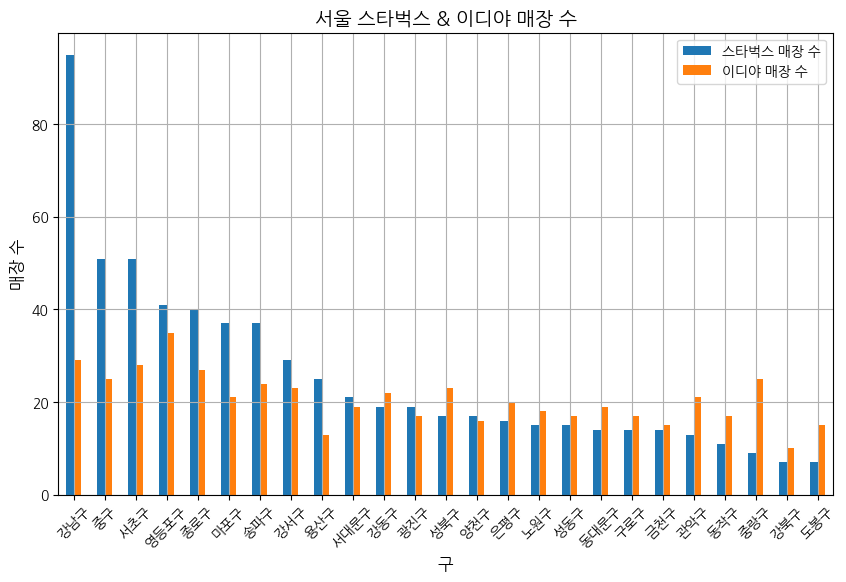

In [53]:
count.plot(kind='bar', figsize=(10,6))

plt.title("서울 스타벅스 & 이디야 매장 수", fontsize=14)
plt.xlabel("구", fontsize=12)
plt.ylabel("매장 수", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid()
plt.show()

* 스타벅스가 가장 많이 위치한 구는 강남구였으며, 그 다음으로 중구, 서초구, 영등포구, 종로구 순이었음
* 반면, 이디야가 가장 많이 위치한 구는 영등포구였으며, 그 다음으로 강남구, 서초구, 종로구, 중구 순이었음
* 스타벅스가 많은 지역에 이디야도 많은지 상관관계를 분석해봄

### 구별 스타벅스 수와 이디아 수의 상관관계

In [54]:
corr = count['스타벅스 매장 수'].corr(count['이디야 매장 수'])
print('스타벅스 수와 이디아 수의 상관계수 r = ', corr)

스타벅스 수와 이디아 수의 상관계수 r =  0.6721061837739033


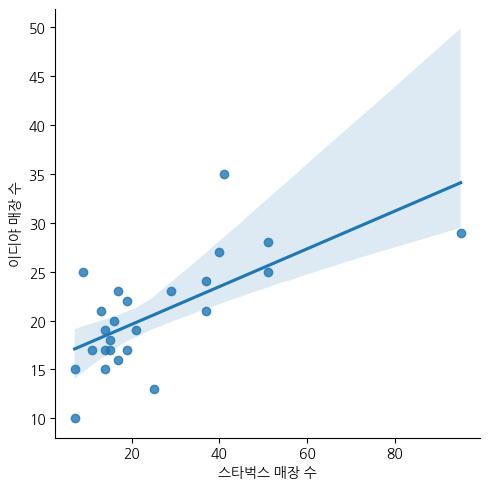

In [55]:
sns.lmplot(x='스타벅스 매장 수', y='이디야 매장 수', data=count)
plt.show()

* 스타벅스 매장 수와 이디야 매장 수는 강하지는 않지만 상관관계가 있는 것으로 파악됨
* 구별로 더 상세히 분석해봄

### 강남구

In [63]:
map = folium.Map(location=[37.497178, 127.062725], zoom_start=13, tiles="OpenStreetMap")

gu_option = '강남구'
for idx, star in df_star.iterrows():
    if star['구'] == gu_option:
        folium.Marker([star['위도'], star['경도']], popup=star['매장명'], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_ediya.iterrows():
    if ediya['구'] == gu_option:
        folium.Marker([ediya['위도'], ediya['경도']], popup=ediya['매장명'], icon=folium.Icon(color='blue')).add_to(map)

map

In [62]:
map.save("map2.html")

* 강남구는 매장들이 너무 밀집되어 있어서 분석하기에 어려움이 있음
* 매장 수가 적은 지역을 보자

### 도봉구

In [64]:
map = folium.Map(location=[37.667232, 127.036897], zoom_start=13, tiles="OpenStreetMap")

gu_option = '도봉구'
for idx, star in df_star.iterrows():
    if star['구'] == gu_option:
        folium.Marker([star['위도'], star['경도']], popup=star['매장명'], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_ediya.iterrows():
    if ediya['구'] == gu_option:
        folium.Marker([ediya['위도'], ediya['경도']], popup=ediya['매장명'], icon=folium.Icon(color='blue')).add_to(map)

map

* 지도 상으로는 파악이 잘 되지 않음
* 위도, 경도를 이용해서 매장 간 거리를 분석해보자

### 스타벅스와 이디야 간 거리 분석

- 분석방법: 서울시 모든 스타벅스 근처에 이디야가 있는지, 있다면 몇 개 있는지 파악
    - '근처' 정의: 스타벅스 매장 기준 반경 250m (보도 3분 거리)
    - 스타벅스와 스타벅스가 있는 구의 모든 이디야 간 거리를 각각 계산하고 그 중 250m 이하인 매장들만 선정
    - 거리계산을 위해 geopy.distance 라이브러리 활용

In [66]:
gu_list = df_star['구'].unique()
gu_list, len(gu_list)

(array(['강남구', '강북구', '강서구', '관악구', '광진구', '금천구', '노원구', '도봉구', '동작구',
        '마포구', '서대문구', '서초구', '성북구', '송파구', '양천구', '영등포구', '은평구', '종로구',
        '중구', '강동구', '구로구', '동대문구', '성동구', '용산구', '중랑구'], dtype=object),
 25)

In [76]:
df_star['구'][0]

'강남구'

In [72]:
from geopy.distance import geodesic

In [141]:
distance_info_all = []
for i, star_row in df_star.iterrows():
    gu = star_row['구']    
    x1 = star_row['경도']
    y1 = star_row['위도']

    distance_info = []    
    for j, ediya_row in df_ediya.iterrows():
        if ediya_row['구'] == gu:
            x2 = ediya_row['경도']
            y2 = ediya_row['위도']
            distance = geodesic((y1, x1), (y2, x2)).m

            if distance <= 250:
                distance_info.append({
                    "매장명": ediya_row["매장명"],
                    "거리": round(distance, 0),
                    "위도": y2,
                    "경도": x2
                })

    distance_info_all.append(distance_info)

df_star["이디야"] = distance_info_all
df_star.head()

,매장명,위도,경도,구,이디야
0,역삼아레나빌딩,37.5011,127.043,강남구,"[{'매장명': '역삼중앙점', '거리': 100.0, '위도': 37.5002, ..."
1,논현역사거리,37.5102,127.022,강남구,[]
2,신사역성일빌딩,37.5139,127.021,강남구,[]
3,국기원사거리,37.4995,127.031,강남구,[]
4,대치재경빌딩,37.4947,127.063,강남구,[]


In [142]:
df_star.to_csv('starbucks.csv', encoding='utf-8')
df_ediya.to_csv('ediya.csv', encoding='utf-8')

In [143]:
df_star

,매장명,위도,경도,구,이디야
0,역삼아레나빌딩,37.5011,127.043,강남구,"[{'매장명': '역삼중앙점', '거리': 100.0, '위도': 37.5002, ..."
1,논현역사거리,37.5102,127.022,강남구,[]
2,신사역성일빌딩,37.5139,127.021,강남구,[]
3,국기원사거리,37.4995,127.031,강남구,[]
4,대치재경빌딩,37.4947,127.063,강남구,[]
...,...,...,...,...,...
629,상봉역,37.5969,127.086,중랑구,"[{'매장명': '서울상봉1동점', '거리': 94.0, '위도': 37.5966,..."
630,묵동,37.6154,127.077,중랑구,[]
631,망우동,37.5995,127.098,중랑구,[]
632,양원역,37.6067,127.106,중랑구,"[{'매장명': '양원역점', '거리': 125.0, '위도': 37.6075, '..."


In [144]:
df_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장명     634 non-null    object 
 1   위도      634 non-null    float64
 2   경도      634 non-null    float64
 3   구       634 non-null    object 
 4   이디야     634 non-null    object 
dtypes: float64(2), object(3)
memory usage: 24.9+ KB


In [145]:
df_star["이디야"].apply(type).unique()

array([<class 'list'>], dtype=object)

In [146]:
df_filtered = df_star[df_star["이디야"].apply(lambda x: len(x) > 0)]
df_filtered.head()


,매장명,위도,경도,구,이디야
0,역삼아레나빌딩,37.5011,127.043,강남구,"[{'매장명': '역삼중앙점', '거리': 100.0, '위도': 37.5002, ..."
12,선릉동신빌딩R,37.5053,127.050,강남구,"[{'매장명': '선릉역점', '거리': 243.0, '위도': 37.5038, '..."
28,을지병원사거리,37.5192,127.029,강남구,"[{'매장명': '을지병원사거리점', '거리': 11.0, '위도': 37.5193..."
29,신사역,37.5162,127.021,강남구,"[{'매장명': '신사역점', '거리': 166.0, '위도': 37.5177, '..."
33,한티역,37.4968,127.055,강남구,"[{'매장명': '한티역점', '거리': 151.0, '위도': 37.4979, '..."


In [147]:
len(df_filtered)

267

* 634개의 스타벅스 중 반경 250m 안에 이디야 매장이 1개 이상 존재하는 매장은 267개(약 42.1%)

### 스타벅스 매장이 적은 관악구, 동작구, 중랑구, 강북구, 도봉구

In [155]:
len(df_star[df_star['구'].isin(['관악구', '동작구', '중랑구', '강북구', '도봉구'])])

47

In [161]:
len(df_filtered[df_filtered['구'].isin(['관악구', '동작구', '중랑구', '강북구', '도봉구'])])

19

* 5개 구에 있는 47개 스타벅스 중 반경 250m 안에 이디야 매장이 1개 이상 존재하는 매장은 19개(약 40.4%)

* 스타벅스 근처에 이디야가 존재할 것이라는 근거가 약해짐

In [166]:
new_data = []

for i, row in df_filtered.iterrows():
    for store in row['이디야']:
        new_data.append({
            '매장명': store['매장명'],            
            '위도': store['위도'],
            '경도': store['경도'],
            '구': row['구'],
            '거리': store['거리'],
        })

df_close = pd.DataFrame(new_data)
df_close.head()

,매장명,위도,경도,구,거리
0,역삼중앙점,37.5002,127.043,강남구,100.0
1,선릉역점,37.5038,127.048,강남구,243.0
2,을지병원사거리점,37.5193,127.029,강남구,11.0
3,신사역점,37.5177,127.021,강남구,166.0
4,한티역점,37.4979,127.056,강남구,151.0


In [169]:
df_not_close = df_ediya[~df_ediya['매장명'].isin(df_close['매장명'])]
df_not_close.reset_index(drop=True, inplace=True)
df_not_close.head()

,매장명,위도,경도,구
0,강남대치점,37.5014,127.052,강남구
1,강남율현점,37.4737,127.108,강남구
2,청담역점,37.5549,126.856,강남구
3,대청역점,37.4942,127.078,강남구
4,개포동역점,37.4885,127.067,강남구


### 스타벅스 인근 이디야 지도 시각화
- 스타벅스 -> 초록색 마커
- 스타벅스에 인접해 있는 이디야 -> 빨간색 마커
- 스타벅스에 인접해 있지 않은 이디야 -> 파란색 마커

In [170]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="Cartodb Positron")

for idx, star in df_star.iterrows():
    folium.Marker([star['위도'], star['경도']], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_not_close.iterrows():
    folium.Marker([ediya['위도'], ediya['경도']], icon=folium.Icon(color='blue')).add_to(map)

for idx, ediya_c in df_close.iterrows():
    folium.Marker([ediya_c['위도'], ediya_c['경도']], icon=folium.Icon(color='red')).add_to(map)

map

### 강남구

In [173]:
map = folium.Map(location=[37.497178, 127.062725], zoom_start=13, tiles="OpenStreetMap")

gu_option = '강남구'
for idx, star in df_star.iterrows():
    if star['구'] == gu_option:
        folium.Marker([star['위도'], star['경도']], popup=star['매장명'], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_not_close.iterrows():
    if ediya['구'] == gu_option:
        folium.Marker([ediya['위도'], ediya['경도']], popup=ediya['매장명'], icon=folium.Icon(color='blue')).add_to(map)

for idx, ediya_c in df_close.iterrows():
    if ediya_c['구'] == gu_option:
        folium.Marker([ediya_c['위도'], ediya_c['경도']], popup=ediya['매장명'], icon=folium.Icon(color='red')).add_to(map)

map

### 도봉구

In [175]:
map = folium.Map(location=[37.667232, 127.036897], zoom_start=13, tiles="OpenStreetMap")

gu_option = '도봉구'
for idx, star in df_star.iterrows():
    if star['구'] == gu_option:
        folium.Marker([star['위도'], star['경도']], popup=star['매장명'], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_not_close.iterrows():
    if ediya['구'] == gu_option:
        folium.Marker([ediya['위도'], ediya['경도']], popup=ediya['매장명'], icon=folium.Icon(color='blue')).add_to(map)

for idx, ediya_c in df_close.iterrows():
    if ediya_c['구'] == gu_option:
        folium.Marker([ediya_c['위도'], ediya_c['경도']], popup=ediya['매장명'], icon=folium.Icon(color='red')).add_to(map)

map

### 강북구

In [176]:
map = folium.Map(location=[37.647295, 127.011433], zoom_start=13, tiles="OpenStreetMap")

gu_option = '강북구'
for idx, star in df_star.iterrows():
    if star['구'] == gu_option:
        folium.Marker([star['위도'], star['경도']], popup=star['매장명'], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_not_close.iterrows():
    if ediya['구'] == gu_option:
        folium.Marker([ediya['위도'], ediya['경도']], popup=ediya['매장명'], icon=folium.Icon(color='blue')).add_to(map)

for idx, ediya_c in df_close.iterrows():
    if ediya_c['구'] == gu_option:
        folium.Marker([ediya_c['위도'], ediya_c['경도']], popup=ediya['매장명'], icon=folium.Icon(color='red')).add_to(map)

map

### 중랑구

In [177]:
map = folium.Map(location=[37.595717, 127.093350], zoom_start=13, tiles="OpenStreetMap")

gu_option = '중랑구'
for idx, star in df_star.iterrows():
    if star['구'] == gu_option:
        folium.Marker([star['위도'], star['경도']], popup=star['매장명'], icon=folium.Icon(color='green')).add_to(map)

for idx, ediya in df_not_close.iterrows():
    if ediya['구'] == gu_option:
        folium.Marker([ediya['위도'], ediya['경도']], popup=ediya['매장명'], icon=folium.Icon(color='blue')).add_to(map)

for idx, ediya_c in df_close.iterrows():
    if ediya_c['구'] == gu_option:
        folium.Marker([ediya_c['위도'], ediya_c['경도']], popup=ediya['매장명'], icon=folium.Icon(color='red')).add_to(map)

map

* 강남구 등은 스타벅스 매장이 많아서 인근에 이디야 매장이 있더라도 이는 우연일 가능성이 더 높다고 판단됨
* 스타벅스 매장이 적은 도봉구, 강북구, 중랑구를 살펴보면, 이디야 매장 중 일부가 스타벅스 매장 근처에 위치하고 있기는 하지만, 전체 이디야 매장 수에 비하면 그 비율은 낮은 편임
* 따라서, 이디야가 전략적으로 스타벅스 매장 근처에 입점한다고 일반화하기에는 어려움이 있을 수 있음